**Exercice : Un GAN conditionnel**

Dans cet exercice, il s'agit d'implémenter un Wasserstein-GAN conditionnel. Les aspects théoriques sont laissés de côté: le but est seulement de construire la boucle d'apprentissage.\
Le contexte est le suivant: on se donne un jeu d'images représentatives d'un domaine $\mathcal{D}$.\
Le GAN classique permet de générer de nouvelles images de $\mathcal{D}$. Dans cet exercice, nous allons générer des images compatibles avec une liste de valeurs de pixels données a priori.

Les cellules suivantes permettent de visualiser le jeu disponible.

In [2]:
# Imports nécessaires
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np

In [3]:
# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

--2024-01-05 11:10:58--  https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679779840 (1.6G) [application/x-tar]
Saving to: ‘L7R8MLxtfzG_NwC5CzNnTSt’

L7R8MLxtfzG_NwC5CzN 100%[===================>]   1.56G  30.0MB/s    in 55s     

2024-01-05 11:11:53 (29.4 MB/s) - ‘L7R8MLxtfzG_NwC5CzNnTSt’ saved [1679779840/1679779840]

data/
data/donut_unet_300ep_step1.pt
data/netG_180ep_WGP_scheduler75_lr005.pt
data/reid_resnet50_60ep.pt
data/tensor_test.pt
data/tensor_test_cpu.pt
data/tensor_train.pt
data/tensor_val.pt
--2024-01-05 11:12:04--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting 

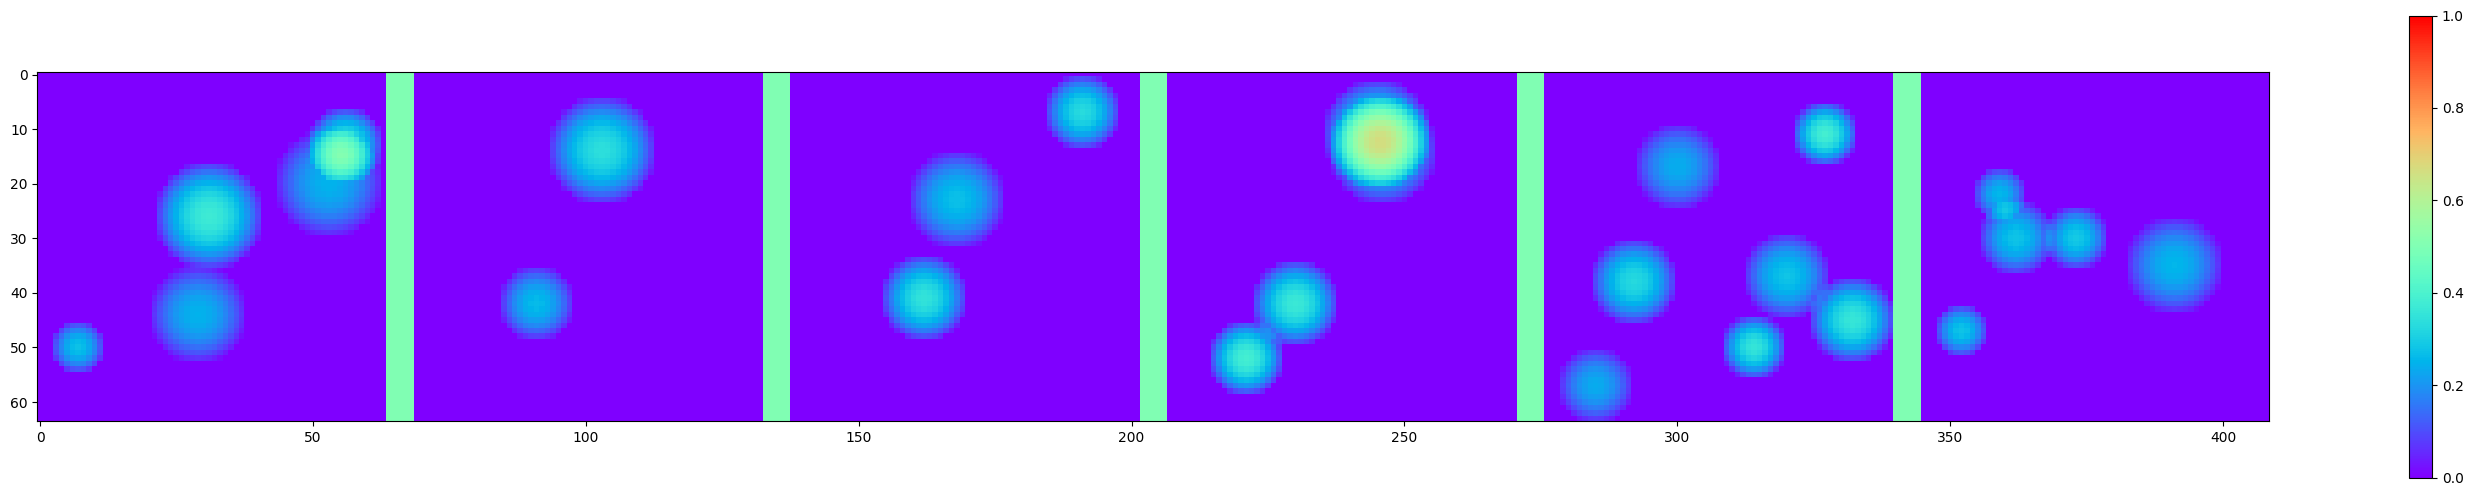

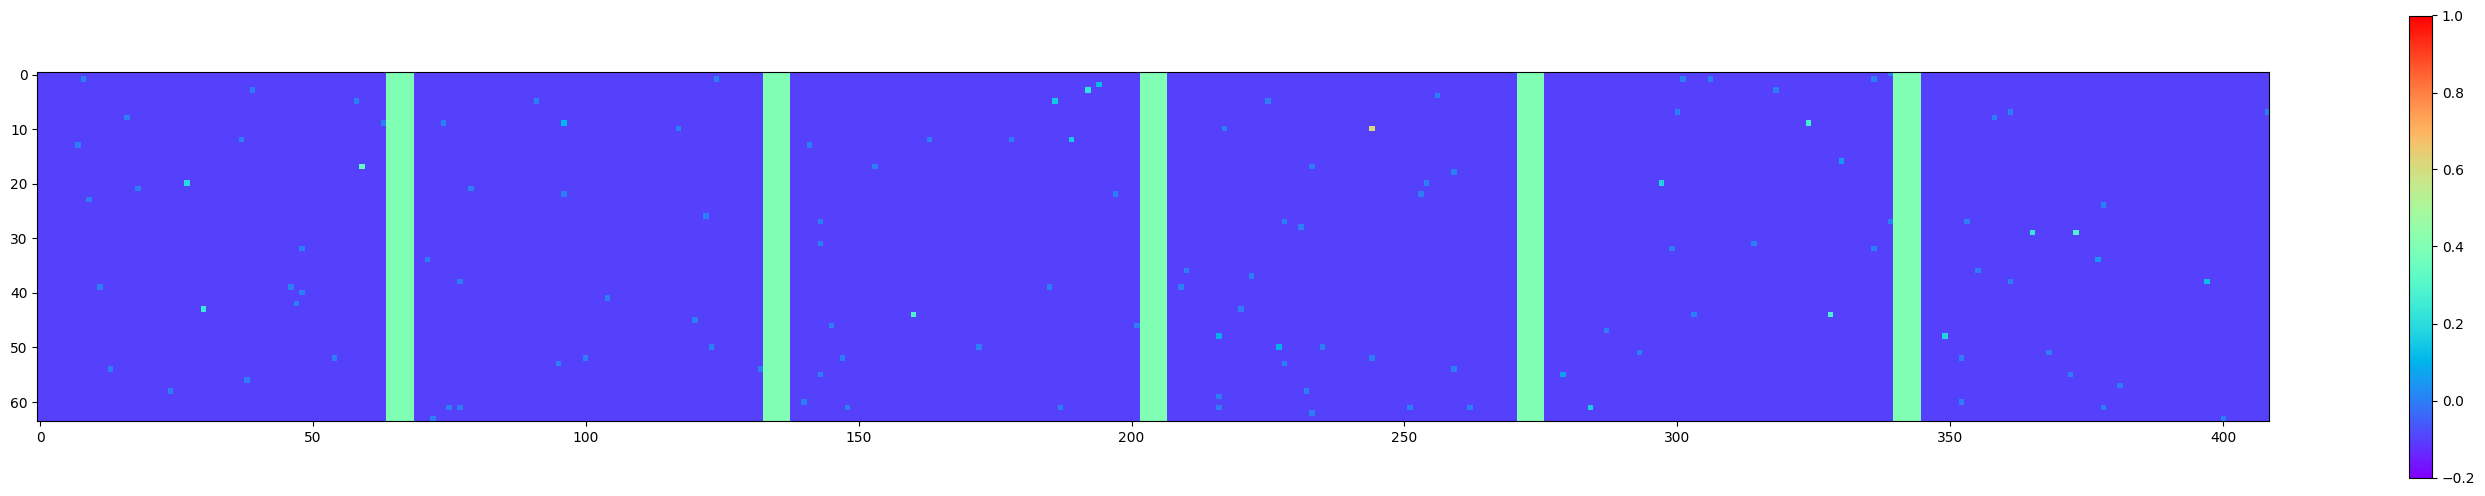

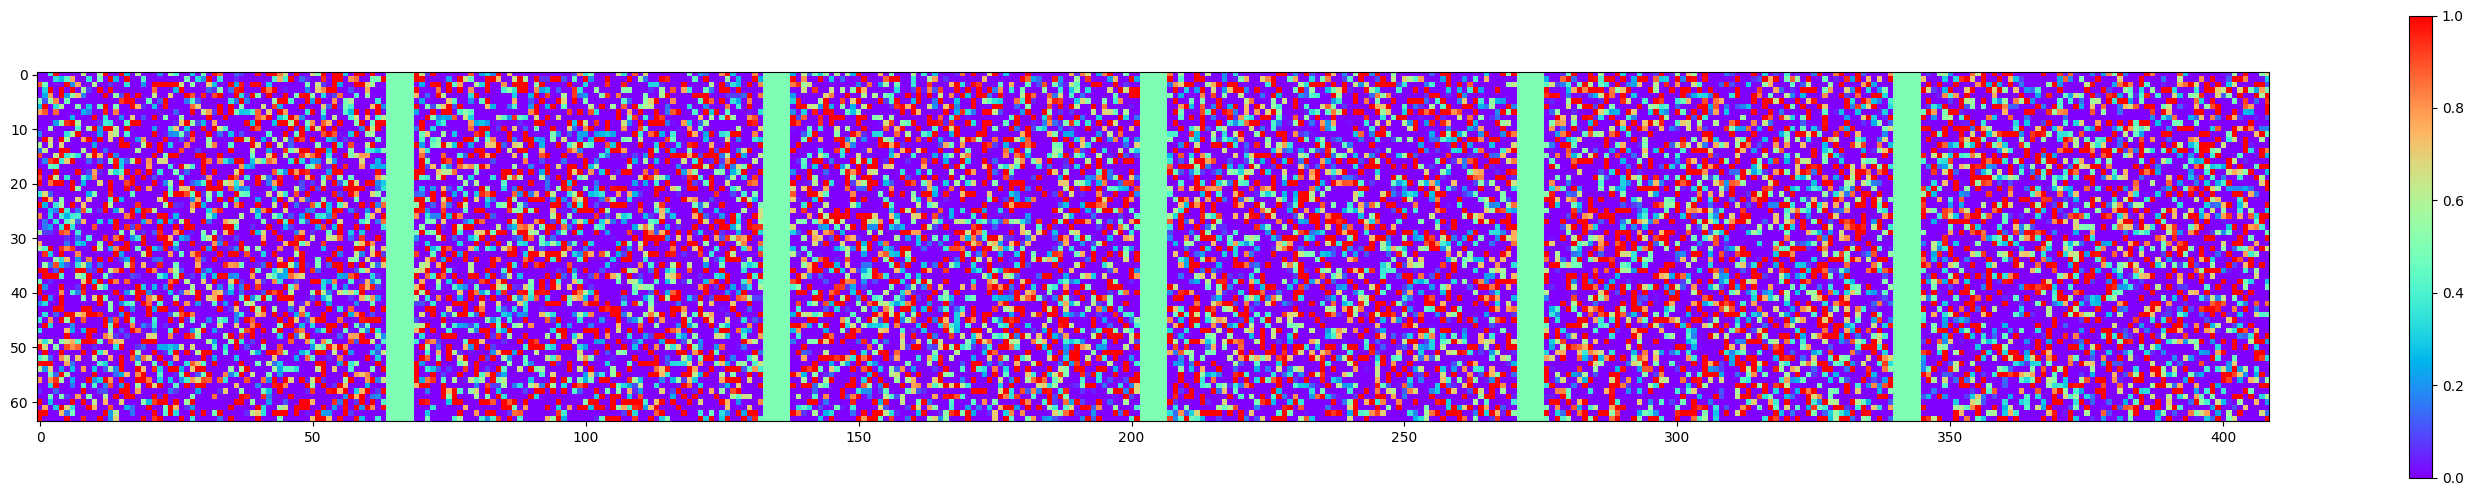

In [4]:
# proportion de pixels conservés dans yi:
dens_obs = 0.005

x , y , z = gen_condDCGAN(6,dens_obs)

# images complètes xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)

# images fragmentaires yi: quelques pixels de xi prélevées au hasard
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2,max_scale=1)

# zi : échantillon d'un vecteur gaussien centré réduit
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)


La première ligne contient un échantillon d'images complètes $x^i$. Ces images représente un champ scalaire à valeurs positives ou nulles.

Pour former les images framgmentaires $y^i$ (seconde ligne d'image), on a sélectionné au hasard 0.5% des pixels de chaque $x^i$, dont on a conservé les valeurs. Les valeurs de tous les autres pixels ont été fixées à -0.1.\
A considérer les $x^i$ (resp. $y^i$) comme l'échantillon d'une variable aléatoire $X$ (resp. $Y$), le but de l'exercice peut se reformuler ainsi: nous allons tenter d'échantilloner la loi $\mathcal{L}_{X|Y}$.

**Q1** Décrire brièvement le GAN classique. De combien de réseaux est-il constitué? Quels sont leur rôles respectifs ?

Le GAN classique comprend un vecteur aléatoire Z, samplé d'une distribution simple, comme par exemple un vecteur gaussien centré réduit, il comprend aussi un réseau générateur d'images G, et enfin un discriminateur D, comprenant une fonction sigmoïde, et qui se charge de classifier les images selon si elles sont réelles ou non.

Le principe du GAN est donc d'entraîner simultanément le discriminateur et le générateur sur des tâches contraires : le discriminateur est entraîné à distinguer les vraies images des images générées par le générateur, et le générateur est entraîné à tromper le discriminateur.

**Q2** Ici, pour le générateur $G$, nous utilisons un FCN. Dans le GAN classique, les entrées sont des réalisations d'un vecteur gaussien centré réduit ($z_i$).\
Pour pouvoir prendre en compte le conditionnement par les $x_i$, $G$ doit prendre en entrée les $z_i$ et les $x_i$ (on les concaténera).\
Justifier que, de son côté, le discriminateur doit prendre en entrée les $G(x_i)$ et les $z_i$.\
Compléter la cellule suivante en conséquence.

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf * 8 * 4 * 4 , 1),
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [47]:
ndf = 32
n_channels = 2
n_classes = 1
size = 16
nc = 2

# les classes UNet et Discriminator sont codées dans utile_BE
netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator().cuda()

**Q3** En vous inspirant de la correction du TP3, compléter la boucle d'apprentissage et la faire tourner sur dix époques:

In [48]:
# Paramétrage de la SGD
batch_size = 128
num_batches_generator = 200
num_epochs = 10

# Paramètres de l'optimizer
lr = 0.0005
beta1 = 0. # inertie de la SGD

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [49]:
real_label = 1.
fake_label = 0.

In [50]:
# Pour garder les traces des images générées à partir d'un échantillon de $z_i$ fixé:
fixed_x , fixed_y , fixed_z = gen_condDCGAN(8, p = dens_obs)

# Entrée fixe du générateur:
fixed_yz = torch.cat((fixed_y,fixed_z), dim=1).cuda()

# Listes
img_list = []
G_losses = []
D_losses = []

# Autres hyper-paramètres
n_critic = 5
clip = 0.01

In [51]:
from re import X
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        ############################
        # (1) maximisation de log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        # Ici, on procède à plusieurs (n_critic) étapes d'optimisation
        # du discriminateur.
        for j in range(n_critic):

            x , y , z = gen_condDCGAN(batch_size, p = dens_obs)

            # mise sur carte GPU
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            # concaténations :

            xy = torch.cat((x,y), dim=1).cuda()
            yz = torch.cat((y,z), dim=1).cuda()

            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()
            fakey = torch.cat((fake,y),dim=1)
            output_fakey = netD(fakey)

            # régularisation par gradient penalty

            gradient_penalty = calculate_gradient_penalty(netD,
                                                              xy.data,
                                                              fakey.data)
            # calcul de l'erreur du discriminateur et mise à jour des gradients:
            errD = gradient_penalty
            errD.backward()

            optimizerD.step()


        ############################
        # Maximisation de log(D(G(z)))
        ###########################
        netG.zero_grad()

        fake = netG(yz)
        fakey = torch.cat((fake,y),dim=1)

        output_fakey = netD(fakey)

        errG = - output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Enregistrement des losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())


    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)




Starting Training Loop...
[1/10][0/200]	Loss_D: 0.8723
[1/10][50/200]	Loss_D: 959.1746
[1/10][100/200]	Loss_D: 42889.3789
[1/10][150/200]	Loss_D: 207435.1094
[2/10][0/200]	Loss_D: 88232.1406
[2/10][50/200]	Loss_D: 473607.3750
[2/10][100/200]	Loss_D: 637665.7500
[2/10][150/200]	Loss_D: 2238806.0000
[3/10][0/200]	Loss_D: 2184990.5000
[3/10][50/200]	Loss_D: 5705750.0000
[3/10][100/200]	Loss_D: 5115415.0000
[3/10][150/200]	Loss_D: 6267862.0000
[4/10][0/200]	Loss_D: 12190202.0000
[4/10][50/200]	Loss_D: 8151636.0000
[4/10][100/200]	Loss_D: 12770747.0000
[4/10][150/200]	Loss_D: 20970048.0000
[5/10][0/200]	Loss_D: 24283684.0000
[5/10][50/200]	Loss_D: 22498044.0000
[5/10][100/200]	Loss_D: 24780488.0000
[5/10][150/200]	Loss_D: 24162144.0000
[6/10][0/200]	Loss_D: 34456812.0000
[6/10][50/200]	Loss_D: 44459264.0000


KeyboardInterrupt: 

**Q5** Visualiser quelques images et commentez.

5


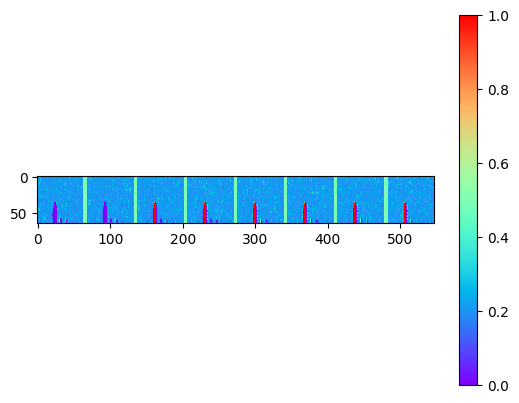

In [53]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)


**Q6** Pour obtenir un GAN qui tienne compte de la condition contenue dans les $y_i$, il est nécessaire de pousser l'apprentissage plus loin. Le fichier *data/netG_180ep_WGP_scheduler75_lr005.pt* contient les poids obtenus après apprentissage sur 300 époques.
Charger ces poids et visualiser plusieurs images pour les mêmes entrée $x_i$ et $z_i$. Vérifier la cohérence et conclure.

In [56]:
weights = torch.load('data/netG_180ep_WGP_scheduler75_lr005.pt')
netG = netG.load_state_dict(weights['model_state_dict'])


AttributeError: '_IncompatibleKeys' object has no attribute 'load_state_dict'

In [ ]:
netG.eval()

x , y , z = gen_condDCGAN(6, p = dens_obs)

...

for i in range(n):
    _ , _ , z = gen_condDCGAN(6, p = dens_obs)

    ...

fig1 = plt.figure(4, figsize=(36, 6))
voir_batch2D(real_and_fakes, 6, fig1, k=0, min_scale=0, max_scale=1)
